Используя базу данных автомобилей, создайте сеть с точностью распознавания не ниже 93% на проверочной выборке.

Для решения задачи вы можете использовать любой подход:
- модель без аугментации данных
- аугментация данных с помощью ImageDataGenerator
- аугментация данных с помощью самописного генератора изображений
- использовать готовую архитектуру из набора `tf.keras.applications` (Обратите внимание: на занятии мы не рассматривали данный модуль фреймворка Керас. Ваша задача: попробовать самостоятельно разобраться в приципах его работы. В разборе домашнего задания вы получите ссылку на ноутбук Базы Знаний УИИ, где подробно раскрывается вопрос использования готовых архитектур)

In [ ]:
import os
import zipfile
from pathlib import Path

import gdown
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import ( Dense,
                                     Dropout,  GlobalAveragePooling2D,
                                     )
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Функция для скачивания и распаковки архива

In [ ]:
def download_and_extract(url, output_dir):
    """Скачивает и распаковывает архив с датасетом"""
    # Создаем папку для данных, если ее нет
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Путь для сохранения архива
    zip_path = os.path.join(output_dir, 'dataset.zip')
    
    # Скачиваем архив
    print("Скачивание архива...")
    gdown.download(url, zip_path, quiet=False)
    
    # Распаковываем архив
    print("Распаковка архива...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    
    # Удаляем архив
    os.remove(zip_path)
    print("Датасет готов к использованию")

Скачивание и распаковка архива

In [ ]:
# Загрузка и распаковка архива
download_and_extract('https://storage.yandexcloud.net/aiueducation/Content/base/l5/middle_fmr.zip', 'cars')

Разделение выборки на train/val/test

In [3]:
# Разделение на train/val/test
TEST_SPLIT = VAL_SPLIT = 0.1
TRAIN_PATH = Path("cars/cars_train")
VAL_PATH = Path("cars/cars_val")
TEST_PATH = Path("cars/cars_test")

if not (TEST_PATH.exists() and VAL_PATH.exists()):
    TEST_PATH.mkdir(exist_ok=True)
    VAL_PATH.mkdir(exist_ok=True)

    for classfolder in TRAIN_PATH.iterdir():
        classfolder_test = TEST_PATH / classfolder.name
        classfolder_val = VAL_PATH / classfolder.name

        classfolder_test.mkdir(exist_ok=True)
        classfolder_val.mkdir(exist_ok=True)

        files = list(classfolder.iterdir())
        len_class = len(files)
        test_len = int(len_class * TEST_SPLIT)
        val_len = int(len_class * VAL_SPLIT)

        for i, img in enumerate(files):
            if i < test_len:
                img.rename(classfolder_test / img.name)
            elif i < test_len + val_len:
                img.rename(classfolder_val / img.name)
            else:
                break

# Генераторы данных
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.05,
    zoom_range=0.2,
    brightness_range=(0.7, 1.3),
    horizontal_flip=True,
    rescale=1.0 / 255.0,
)

test_and_val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

IMG_HEIGHT = 108
IMG_WIDTH = 192
BATCH_SIZE = 64

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, class_mode="categorical", shuffle=True
)

validation_generator = test_and_val_datagen.flow_from_directory(
    VAL_PATH, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, class_mode="categorical", shuffle=True
)

test_generator = test_and_val_datagen.flow_from_directory(
    TEST_PATH, target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE, class_mode="categorical", shuffle=False
)

print("Train class distribution:", np.bincount(train_generator.classes))
print("Validation class distribution:", np.bincount(validation_generator.classes))
print("Test class distribution:", np.bincount(test_generator.classes))

Found 2745 images belonging to 3 classes.
Found 341 images belonging to 3 classes.
Found 341 images belonging to 3 classes.
Train class distribution: [872 929 944]
Validation class distribution: [108 116 117]
Test class distribution: [108 116 117]


Вывод получившихся выборок

In [5]:

print("Train class distribution:", np.bincount(train_generator.classes))
print("Validation class distribution:", np.bincount(validation_generator.classes))
print("Test class distribution:", np.bincount(test_generator.classes))

Train class distribution: [872 929 944]
Validation class distribution: [108 116 117]
Test class distribution: [108 116 117]


Создание модели на базе VGG19

In [6]:
base_model = VGG19(
        weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )

for layer in base_model.layers:
  layer.trainable = False


for layer in base_model.layers[-5:]:
  layer.trainable = True

model = Sequential(
        [
            base_model,
            GlobalAveragePooling2D(),
            Dropout(0.6),
            Dense(512, activation="relu"),
            Dropout(0.6),
            Dense(3, activation="softmax"),
        ]
    )

model.compile(
        optimizer=SGD(learning_rate=0.003, momentum=0.9),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Вывод структуры модели

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 3, 6, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,288,579 (77.39 MB)

 Trainable params: 9,703,427 (37.02 MB)

 Non-trainable params: 10,585,152 (40.38 MB)

Обучение модели

In [9]:
# Автоматическое использование GPU
with tf.device('/GPU:0'):

    # Обучение
    history = model.fit(
        train_generator,
        epochs=150,
        validation_data=validation_generator,
         verbose=1
    )


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.3567 - loss: 1.2974 - val_accuracy: 0.3431 - val_loss: 1.0887
Epoch 2/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 533ms/step - accuracy: 0.3516 - loss: 1.0959 - val_accuracy: 0.3548 - val_loss: 1.0620
Epoch 3/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 529ms/step - accuracy: 0.4111 - loss: 1.0666 - val_accuracy: 0.4956 - val_loss: 0.9408
Epoch 4/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 526ms/step - accuracy: 0.5097 - loss: 1.0143 - val_accuracy: 0.5806 - val_loss: 0.8768
Epoch 5/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 544ms/step - accuracy: 0.5817 - loss: 0.9437 - val_accuracy: 0.7889 - val_loss: 0.7773
Epoch 6/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 549ms/step - accuracy: 0.6479 - loss: 0.8710 - val_accuracy: 0.7977 - val_loss: 0.6355
Epoch 7/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 24s 546ms/step - accuracy: 0.7235 - loss: 0.7401 - val_accuracy: 0.8651 - val_loss: 0.4935
Epoch 8/150
43/43 ━━━━━━━━━━━━━━━━━━━━ 29s 685ms/step - accuracy: 0.7677 - loss: 0.6415 - val

Визуализация обучения модели и вывод точности

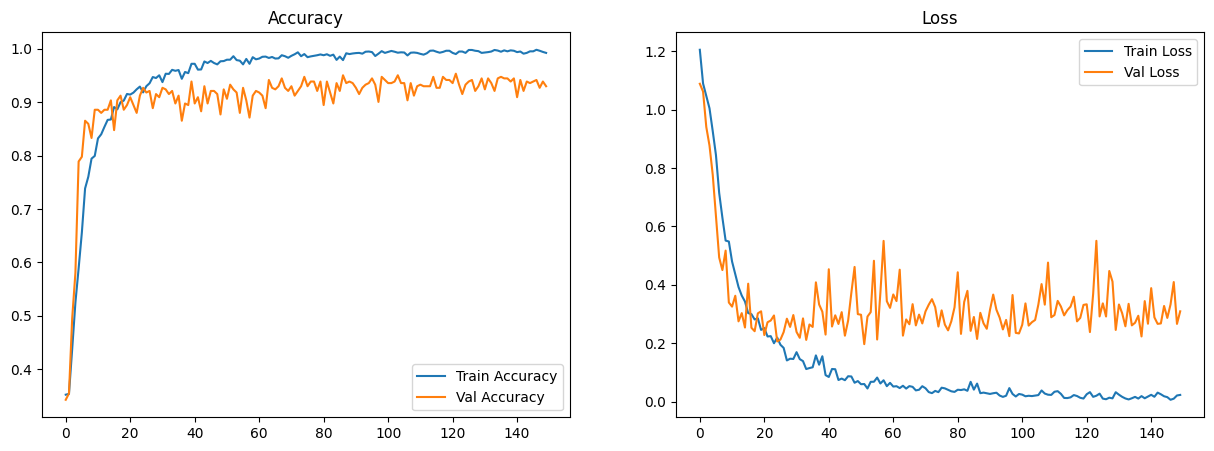

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.9350 - loss: 0.2993

Validation Accuracy: 92.96%
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


In [11]:
# Визуализация обучения
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Оценка точности на валидационной выборке
val_loss, val_acc = model.evaluate(validation_generator)
print(f'\nValidation Accuracy: {val_acc:.2%}')

# Вывод матрицы ошибок
y_true = validation_generator.classes
y_pred = np.argmax(model.predict(validation_generator), axis=1)

plt.show()